<a href="https://colab.research.google.com/github/mshitie/MS_KD/blob/main/WithoutKD/WithoutKD_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install rarfile

from google.colab import drive
import rarfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to the .rar file in Google Drive
rar_path = '/content/drive/MyDrive/computer_vision/main_data_croped.rar'

# Destination folder to extract the contents
destination_folder = '/content'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Extract the .rar file
with rarfile.RarFile(rar_path, 'r') as rar_ref:
    rar_ref.extractall(destination_folder)

print("Extraction completed.")

Mounted at /content/drive
Extraction completed.


In [2]:
import os
import csv
import shutil

def partition_images(directory, csv_file, output_folder):
    image_files = []
    folder_counts = {}  # Dictionary to store the count of images moved to each folder

    # Read the CSV file
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        header = next(reader, None)  # Skip the header row if it exists

        # Iterate over the rows in the CSV file
        for row in reader:
            image_file = row[0]  # Assuming the image file names are in the first column
            label = row[1]  # Assuming the labels are in the second column
            image_files.append((image_file, label))

    # Create directories for each label
    labels = set(label for _, label in image_files)
    for label in labels:
        label_dir = os.path.join(output_folder, label)
        os.makedirs(label_dir, exist_ok=True)
        folder_counts[label] = 0  # Initialize the count to 0

    # Move the image files to separate label directories
    for image_file, label in image_files:
        source_path = os.path.join(directory, image_file + ".jpg")  # Assuming the file extension is '.jpg'
        destination_path = os.path.join(output_folder, label, image_file + ".jpg")

        if os.path.exists(source_path):
            print(f"Moving {source_path} to {destination_path}")
            shutil.move(source_path, destination_path)
            folder_counts[label] += 1  # Increment the count for the corresponding folder

        else:
            print(f"File not found: {source_path}")

    # Print the counts for each folder
    print("\nNumber of images moved in each folder:")
    for label, count in folder_counts.items():
        print(f"{label}: {count}")

# Directory path where the images and CSV file are located
directory_path = '/content/main_data_croped/'
csv_file_path = '/content/drive/MyDrive/computer_vision/tfti2.csv'
output_folder = "/content/main_data_croped2/"

# Create the output directory if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Call the function to partition the images based on the labels
partition_images(directory_path, csv_file_path, output_folder)

Moving /content/main_data_croped/image1.jpg to /content/main_data_croped2/1/image1.jpg
Moving /content/main_data_croped/image2.jpg to /content/main_data_croped2/2/image2.jpg
Moving /content/main_data_croped/image3.jpg to /content/main_data_croped2/1/image3.jpg
Moving /content/main_data_croped/image4.jpg to /content/main_data_croped2/1/image4.jpg
Moving /content/main_data_croped/image5.jpg to /content/main_data_croped2/2/image5.jpg
Moving /content/main_data_croped/image6.jpg to /content/main_data_croped2/3/image6.jpg
Moving /content/main_data_croped/image7.jpg to /content/main_data_croped2/1/image7.jpg
Moving /content/main_data_croped/image8.jpg to /content/main_data_croped2/4/image8.jpg
Moving /content/main_data_croped/image9.jpg to /content/main_data_croped2/1/image9.jpg
Moving /content/main_data_croped/image10.jpg to /content/main_data_croped2/4/image10.jpg
Moving /content/main_data_croped/image11.jpg to /content/main_data_croped2/2/image11.jpg
Moving /content/main_data_croped/image1

In [3]:
import os
import cv2
from PIL import Image
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_curve
from tqdm import tqdm

import time

<ipython-input-3-c760a79cdaf2>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [4]:
# Keras & Tensorflow
import keras
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.layers import Lambda, concatenate
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D , Conv2D , MaxPooling2D
from keras.layers import  Dropout , BatchNormalization , Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy

In [5]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

train_dir = '/content/main_data_croped2'

# Load train images
tf_train = []
for filename in os.listdir(os.path.join(train_dir, 'TF')):
    img = Image.open(os.path.join(train_dir, 'TF', filename)).convert('RGB')
    img = img.resize((224, 224))  # Resize if necessary
    img_array = np.array(img)
    tf_train.append(img_array)
tf_train = np.array(tf_train)

it_train = []
for filename in os.listdir(os.path.join(train_dir, 'TI')):
    img = Image.open(os.path.join(train_dir, 'TI', filename)).convert('RGB')
    img = img.resize((224, 224))  # Resize if necessary
    img_array = np.array(img)
    it_train.append(img_array)
it_train = np.array(it_train)

normal_train = []
for filename in os.listdir(os.path.join(train_dir, 'normal')):
    img = Image.open(os.path.join(train_dir, 'normal', filename)).convert('RGB')
    img = img.resize((224, 224))  # Resize if necessary
    img_array = np.array(img)
    normal_train.append(img_array)
normal_train = np.array(normal_train)

print('Done Loaded :)')

# Shape of our dataset
print(f'TF Train:', tf_train.shape)
print(f'TI Train:', it_train.shape)
print(f'Normal Train:', normal_train.shape)

tf_train_label = np.zeros(len(tf_train), dtype=float)
it_train_label = np.ones(len(it_train), dtype=float)
normal_train_label = np.full(len(normal_train), 2, dtype=float)

X_train = np.concatenate((tf_train, it_train, normal_train), axis=0)
Y_train = np.concatenate((tf_train_label, it_train_label, normal_train_label), axis=0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

Y_train = to_categorical(Y_train, num_classes=3)

print(f'X train shape:', X_train.shape)
print(f'Y train shape:', Y_train.shape)

# Split the data into training, validation, and testing sets
x_train, x_temp, y_train, y_temp = train_test_split(X_train, Y_train, test_size=0.2, random_state=10)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=10)

print(f'x train shape:', x_train.shape)
print(f'x test shape:', x_test.shape)
print(f'x val shape:', x_val.shape)
print(f'y train shape:', y_train.shape)
print(f'y test shape:', y_test.shape)
print(f'y val shape:', y_val.shape)

Done Loaded :)
TF Train: (365, 224, 224, 3)
TI Train: (110, 224, 224, 3)
Normal Train: (1019, 224, 224, 3)
X train shape: (1494, 224, 224, 3)
Y train shape: (1494, 3)
x train shape: (1195, 224, 224, 3)
x test shape: (150, 224, 224, 3)
x val shape: (149, 224, 224, 3)
y train shape: (1195, 3)
y test shape: (150, 3)
y val shape: (149, 3)


In [6]:

# MobileNet
from tensorflow.keras.applications import MobileNet

def mobile_model1(backbone , lr = 1e-4):
  model1 = Sequential()
  model1.add(backbone)
  model1.add(layers.GlobalAveragePooling2D())
  model1.add(layers.Dropout(0.5))
  model1.add(layers.BatchNormalization())
  model1.add(layers.Dense(3 , activation='softmax'))

  model1.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )

  return model1


mobilenet1 = MobileNet(
    weights = 'imagenet',
    include_top = False,
    input_shape =(224 , 224 , 3)
)
#call the model
model1 = mobile_model1(mobilenet1 , lr = 1e-4)
model1.build((None, 224, 224, 3))
model1.summary()

17225924/17225924 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 3)                 30

In [7]:
# Training the teacher model with Resnet50
# Train the teacher model as usual
epochs = 20
batch_size = 64
teacher_his = model1.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val))


Epoch 1/20
19/19 [==============================] - 49s 448ms/step - loss: 1.2393 - accuracy: 0.4996 - val_loss: 4.8936 - val_accuracy: 0.1007
Epoch 2/20
19/19 [==============================] - 4s 230ms/step - loss: 0.8254 - accuracy: 0.6854 - val_loss: 4.0734 - val_accuracy: 0.2550
Epoch 3/20
19/19 [==============================] - 4s 217ms/step - loss: 0.6060 - accuracy: 0.7824 - val_loss: 1.9024 - val_accuracy: 0.3423
Epoch 4/20
19/19 [==============================] - 4s 220ms/step - loss: 0.4200 - accuracy: 0.8561 - val_loss: 1.3598 - val_accuracy: 0.5302
Epoch 5/20
19/19 [==============================] - 4s 230ms/step - loss: 0.3042 - accuracy: 0.8904 - val_loss: 1.5313 - val_accuracy: 0.4899
Epoch 6/20
19/19 [==============================] - 4s 231ms/step - loss: 0.2236 - accuracy: 0.9272 - val_loss: 1.1115 - val_accuracy: 0.6711
Epoch 7/20
19/19 [==============================] - 4s 238ms/step - loss: 0.1742 - accuracy: 0.9464 - val_loss: 0.8438 - val_accuracy: 0.7718
Epoch

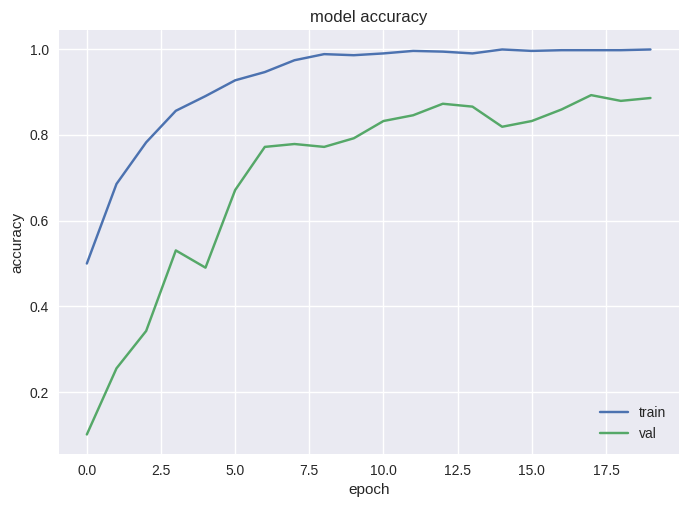

In [8]:

#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['accuracy'],)
plt.plot(teacher_his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

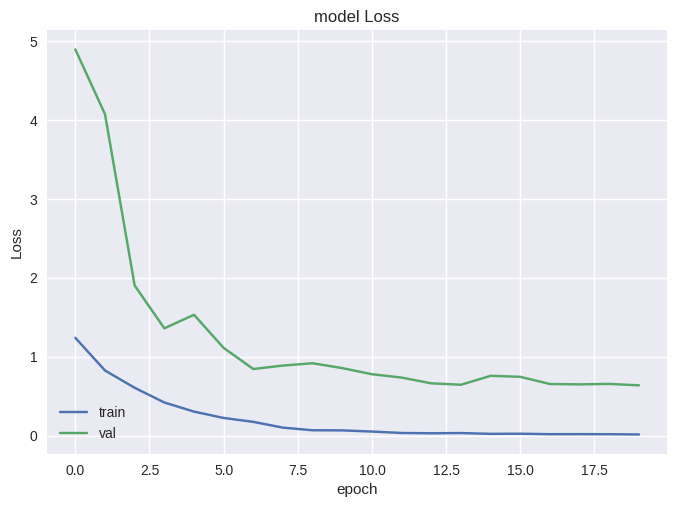

In [9]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['loss'])
plt.plot(teacher_his.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

In [10]:
Y_val_pred = model1.predict(x_val)
print(f'The Teacher model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1)))


5/5 [==============================] - 1s 27ms/step
The Teacher model Accuracy on the Validation Set: 0.8859060402684564


In [11]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,y_test)

My Y_test values are:
 [[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 

In [12]:
#Now let's check my predcited values from X_test dataset
# And calculate the y_pred with time
import timeit

start = timeit.default_timer()
#Your statements here
y_pred = model1.predict(x_test)
print(f'My predicted Y_test values are:\n' ,y_pred)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

5/5 [==============================] - 1s 140ms/step
My predicted Y_test values are:
 [[1.94130262e-05 3.30035295e-03 9.96680260e-01]
 [4.80452403e-02 1.32259533e-01 8.19695234e-01]
 [1.22955814e-02 9.37503483e-03 9.78329360e-01]
 [2.20825985e-01 4.62523988e-03 7.74548769e-01]
 [2.93761805e-05 1.86462468e-03 9.98106003e-01]
 [9.99637008e-01 3.61784740e-04 1.21295329e-06]
 [2.80103442e-04 7.31591950e-04 9.98988330e-01]
 [9.99035954e-01 9.64046922e-04 2.21072591e-10]
 [9.77849841e-01 2.21494529e-02 7.32716444e-07]
 [2.09845603e-05 7.80388073e-05 9.99900937e-01]
 [1.02792155e-05 2.76565814e-04 9.99713123e-01]
 [9.99955654e-01 4.43725476e-05 5.83981474e-12]
 [1.29198481e-04 3.50412709e-04 9.99520421e-01]
 [9.75499928e-01 6.57423399e-03 1.79257281e-02]
 [4.10378367e-01 1.00891069e-01 4.88730520e-01]
 [9.27470922e-01 7.25290477e-02 2.10036259e-11]
 [6.24613464e-03 9.66405030e-03 9.84089851e-01]
 [4.91911871e-03 2.67157075e-03 9.92409348e-01]
 [1.58373579e-01 8.40230346e-01 1.39608083e-03]
 [

In [13]:
#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy:',accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

My accuracy: 0.82


In [14]:
# Print the classification report
print(classification_report( np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.64      0.59      0.62        27
           1       0.57      0.67      0.62        12
           2       0.89      0.89      0.89       111

    accuracy                           0.82       150
   macro avg       0.70      0.72      0.71       150
weighted avg       0.82      0.82      0.82       150

